# MNIST-Neural Network-Two Hidden Layers with Backward Propagation

In [1]:
# coding: utf-8
import urllib.request
import os.path
import gzip
import pickle
import os
import numpy as np

url_base = 'http://yann.lecun.com/exdb/mnist/'
key_file = {
    'train_img':'train-images-idx3-ubyte.gz',
    'train_label':'train-labels-idx1-ubyte.gz',
    'test_img':'t10k-images-idx3-ubyte.gz',
    'test_label':'t10k-labels-idx1-ubyte.gz'
}

dataset_dir = os.path.dirname("/Users/yhhan/git/aiclass/0.Professor/3.VanillaNN/MNIST_data/.")
save_file = dataset_dir + "/mnist.pkl"

train_num = 60000
test_num = 10000
img_dim = (1, 28, 28)
img_size = 784

def _download(file_name):
    file_path = dataset_dir + "/" + file_name
    print(file_path)
    if os.path.exists(file_path):
        return

    print("Downloading " + file_name + " ... ")
    urllib.request.urlretrieve(url_base + file_name, file_path)
    print("Done")
    
def download_mnist():
    for v in key_file.values():
       _download(v)
        
def _load_label(file_name):
    file_path = dataset_dir + "/" + file_name
    
    print("Converting " + file_name + " to NumPy Array ...")
    with gzip.open(file_path, 'rb') as f:
            labels = np.frombuffer(f.read(), np.uint8, offset=8)
    print("Done")
    
    return labels

def _load_img(file_name):
    file_path = dataset_dir + "/" + file_name
    
    print("Converting " + file_name + " to NumPy Array ...")    
    with gzip.open(file_path, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1, img_size)
    print("Done")
    
    return data
    
def _convert_numpy():
    dataset = {}
    dataset['train_img'] =  _load_img(key_file['train_img'])
    dataset['train_label'] = _load_label(key_file['train_label'])
    dataset['test_img'] = _load_img(key_file['test_img'])
    dataset['test_label'] = _load_label(key_file['test_label'])

    dataset['validation_img'] = dataset['train_img'][55000:]
    dataset['validation_label'] = dataset['train_label'][55000:]
    dataset['train_img'] =  dataset['train_img'][:55000]
    dataset['train_label'] = dataset['train_label'][:55000]
    return dataset

def init_mnist():
    download_mnist()
    dataset = _convert_numpy()
    print("Creating pickle file ...")
    with open(save_file, 'wb') as f:
        pickle.dump(dataset, f, -1)
    print("Done!")

def _change_one_hot_label(X):
    T = np.zeros((X.size, 10))
    for idx, row in enumerate(T):
        row[X[idx]] = 1
        
    return T

def load_mnist(normalize=True, flatten=True, one_hot_label=False):
    if not os.path.exists(save_file):
        init_mnist()
        
    with open(save_file, 'rb') as f:
        dataset = pickle.load(f)
    
    if normalize:
        for key in ('train_img', 'validation_img', 'test_img'):
            dataset[key] = dataset[key].astype(np.float32)
            dataset[key] /= 255.0
            
    if one_hot_label:
        dataset['train_label'] = _change_one_hot_label(dataset['train_label'])
        dataset['validation_label'] = _change_one_hot_label(dataset['validation_label'])
        dataset['test_label'] = _change_one_hot_label(dataset['test_label'])
    
    if not flatten:
         for key in ('train_img', 'validation_img', 'test_img'):
            dataset[key] = dataset[key].reshape(-1, 1, 28, 28)

    return (dataset['train_img'], dataset['train_label']), (dataset['validation_img'], dataset['validation_label']), (dataset['test_img'], dataset['test_label']) 


if __name__ == '__main__':
    init_mnist()

/Users/yhhan/git/aiclass/0.Professor/3.VanillaNN/MNIST_data/train-images-idx3-ubyte.gz
/Users/yhhan/git/aiclass/0.Professor/3.VanillaNN/MNIST_data/train-labels-idx1-ubyte.gz
/Users/yhhan/git/aiclass/0.Professor/3.VanillaNN/MNIST_data/t10k-images-idx3-ubyte.gz
/Users/yhhan/git/aiclass/0.Professor/3.VanillaNN/MNIST_data/t10k-labels-idx1-ubyte.gz
Converting train-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting train-labels-idx1-ubyte.gz to NumPy Array ...
Done
Converting t10k-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting t10k-labels-idx1-ubyte.gz to NumPy Array ...
Done
Creating pickle file ...
Done!


## Each Layer Definition with Forward and Backward Functions

In [2]:
import numpy as np

def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x)
    return np.exp(x) / np.sum(np.exp(x))

def cross_entropy_error(y, t):
    #print(y.shape, t.shape)
    if y.ndim == 1:
        y = y.reshape(1, y.size)
        t = t.reshape(1, t.size)

    if t.size == y.size:
        t = t.argmax(axis=1)

    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t])) / batch_size

class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        return out

    def backward(self, din):
        din[self.mask] = 0
        dx = din
        return dx

class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = sigmoid(x)
        self.out = out
        return out

    def backward(self, din):
        dx = din * self.out * (1.0 - self.out)
        return dx

class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b        
        self.x = None
        self.dW = None
        self.db = None

    def forward(self, x):
        self.x = x
        out = np.dot(self.x, self.W) + self.b
        return out

    def backward(self, din):
        dx = np.dot(din, self.W.T)
        self.dW = np.dot(self.x.T, din)
        self.db = np.sum(din, axis=0)
        return dx

class SoftmaxWithCrossEntropyLoss:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None
    
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        return self.loss

    def backward(self, din=1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / float(batch_size)        
        return dx

## Multilayer Neural Network Model

In [3]:
import sys, os
from collections import OrderedDict
from scipy import stats
from pandas import DataFrame

class TwoLayerNet2:
    def __init__(self, input_size, hidden_layer1_size, hidden_layer2_size, output_size, weight_init_std = 0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_layer1_size)
        self.params['b1'] = np.zeros(hidden_layer1_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_layer1_size, hidden_layer2_size)
        self.params['b2'] = np.zeros(hidden_layer2_size)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_layer2_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine3'] = Affine(self.params['W3'], self.params['b3'])

        self.lastLayer = SoftmaxWithCrossEntropyLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
        
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    def backpropagation_gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        din = 1
        din = self.lastLayer.backward(din)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            din = layer.backward(din)

        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        grads['W3'], grads['b3'] = self.layers['Affine3'].dW, self.layers['Affine3'].db

        return grads
    
    def learning(self, learning_rate, x_batch, t_batch):
        grads = self.backpropagation_gradient(x_batch, t_batch)
        for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
            self.params[key] -= learning_rate * grads[key]

## Learning and Validation

In [4]:
import math

(img_train, label_train), (img_validation, label_validation), (img_test, label_test) = load_mnist(flatten=True, normalize=True, one_hot_label=True)

network = TwoLayerNet2(input_size=784, hidden_layer1_size=128, hidden_layer2_size=128, output_size=10)

num_epochs = 50
train_size = img_train.shape[0]
batch_size = 1000
learning_rate = 0.1

train_error_list = []
validation_error_list = []

test_accuracy_list = []
epoch_list = []

num_batch = math.ceil(train_size / batch_size)

for i in range(num_epochs):
#     batch_mask = np.random.choice(train_size, batch_size)
#     x_batch = img_train[batch_mask]
#     t_batch = label_train[batch_mask]
#     network.learning(learning_rate, x_batch, t_batch)
    for j in range(num_batch):
        x_batch = img_train[j * batch_size : j * batch_size + batch_size]
        t_batch = label_train[j * batch_size : j * batch_size + batch_size]
        network.learning(learning_rate, x_batch, t_batch)

    epoch_list.append(i)
    
    train_loss = network.loss(x_batch, t_batch)
    train_error_list.append(train_loss)
    
    validation_loss = network.loss(img_validation, label_validation)
    validation_error_list.append(validation_loss)    
    
    test_accuracy = network.accuracy(img_test, label_test)
    test_accuracy_list.append(test_accuracy)       
    
    print("Epoch: {0:5d}, Train Error: {1:7.5f}, Validation Error: {2:7.5f} - Test Accuracy: {3:7.5f}".format(
        i,
        train_loss,
        validation_loss,
        test_accuracy
    ))

Epoch:     0, Train Error: 2.30146, Validation Error: 2.30121 - Test Accuracy: 0.11350
Epoch:     1, Train Error: 2.30005, Validation Error: 2.29964 - Test Accuracy: 0.11350
Epoch:     2, Train Error: 2.29561, Validation Error: 2.29504 - Test Accuracy: 0.11350
Epoch:     3, Train Error: 2.26272, Validation Error: 2.26201 - Test Accuracy: 0.21120
Epoch:     4, Train Error: 1.97740, Validation Error: 1.97533 - Test Accuracy: 0.31750
Epoch:     5, Train Error: 1.31977, Validation Error: 1.29441 - Test Accuracy: 0.57490
Epoch:     6, Train Error: 0.82184, Validation Error: 0.77294 - Test Accuracy: 0.73140
Epoch:     7, Train Error: 0.66929, Validation Error: 0.60766 - Test Accuracy: 0.78420
Epoch:     8, Train Error: 0.60268, Validation Error: 0.53676 - Test Accuracy: 0.81470
Epoch:     9, Train Error: 0.55257, Validation Error: 0.48464 - Test Accuracy: 0.83680
Epoch:    10, Train Error: 0.50546, Validation Error: 0.43600 - Test Accuracy: 0.84990
Epoch:    11, Train Error: 0.46836, Validat

## Analysis with Graph

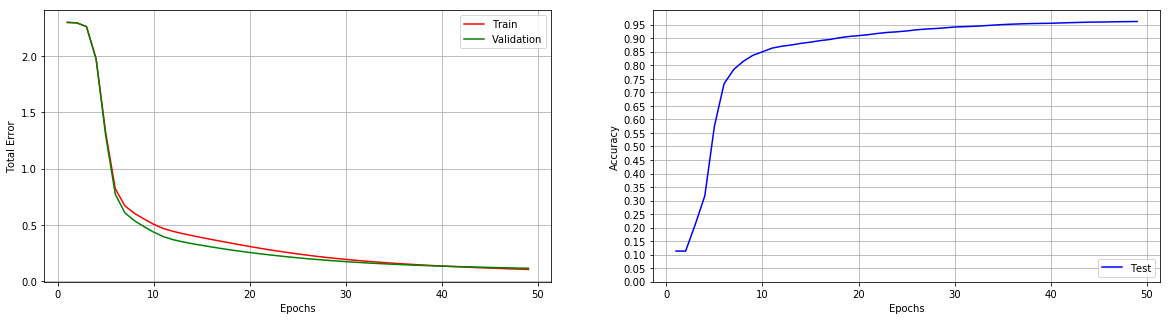

[7 2 1 ..., 4 5 6]
[7 2 1 ..., 4 5 6]
Total Test Image: 10000, Number of False Prediction: 381
Test Accuracy: 0.9619
False Prediction Index: 8, Prediction: 6, Ground Truth: 5
False Prediction Index: 124, Prediction: 4, Ground Truth: 7
False Prediction Index: 149, Prediction: 9, Ground Truth: 2
False Prediction Index: 151, Prediction: 8, Ground Truth: 9
False Prediction Index: 233, Prediction: 7, Ground Truth: 8


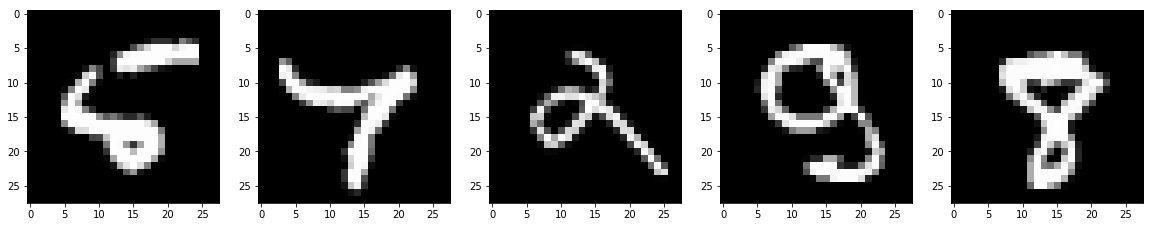

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
# Draw Graph about Error Values & Accuracy Values
def draw_error_values_and_accuracy(epoch_list, train_error_list, validation_error_list, test_accuracy_list):
    # Draw Error Values and Accuracy
    fig = plt.figure(figsize=(20, 5))
    plt.subplot(121)
    plt.plot(epoch_list[1:], train_error_list[1:], 'r', label='Train')
    plt.plot(epoch_list[1:], validation_error_list[1:], 'g', label='Validation')
    plt.ylabel('Total Error')
    plt.xlabel('Epochs')
    plt.grid(True)
    plt.legend(loc='upper right')

    plt.subplot(122)
    plt.plot(epoch_list[1:], test_accuracy_list[1:], 'b', label='Test')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.yticks(np.arange(0.0, 1.0, 0.05))
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.show()

draw_error_values_and_accuracy(epoch_list, train_error_list, validation_error_list, test_accuracy_list)
    
def draw_false_prediction(diff_index_list):
    fig = plt.figure(figsize=(20, 5))
    for i in range(5):
        j = diff_index_list[i]
        print("False Prediction Index: %s, Prediction: %s, Ground Truth: %s" % (j, prediction[j], ground_truth[j]))
        img = np.array(img_test[j])
        img.shape = (28, 28)
        plt.subplot(150 + (i+1))
        plt.imshow(img, cmap='gray')
        
prediction = np.argmax(network.predict(img_test), axis=1)
ground_truth = np.argmax(label_test, axis=1)
        
print(prediction)
print(ground_truth)

diff_index_list = []
for i in range(len(img_test)):
    if (prediction[i] != ground_truth[i]):
        diff_index_list.append(i)

print("Total Test Image: {0}, Number of False Prediction: {1}".format(len(img_test), len(diff_index_list)))
print("Test Accuracy:", float(len(img_test) - len(diff_index_list)) / float(len(img_test)))
draw_false_prediction(diff_index_list)